In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import  RidgeCV
import shap
import numpy as np
import pandas as pd
from collections import OrderedDict


/Users/hungnguyen/miniforge3/envs/REDI/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/hungnguyen/miniforge3/envs/REDI/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def del

In [2]:
def get_score(model, feature, target):
    pred = model.predict(feature)
    score = pd.DataFrame(pred, columns=['Prediction'], index=feature.index)
    score['GroundTruth'] = np.array(target)
    score['AbsoluteError'] = abs(score['GroundTruth'] - score['Prediction'])
    return score

def get_doubtful_values(score):
    return score[score['AbsoluteError'] > 1.5]

def get_truthful_values(score):
    return score[score['AbsoluteError'] < 0.5]


In [3]:
data = pd.read_csv("data/data_cleaned.csv")
data = data.drop(["Unnamed: 0"], axis=1)

In [4]:
y = data["OverallQual"]
X = data.drop(["OverallQual", 'SalePrice'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=100, stratify=y )

ridge = RidgeCV()
ridge.fit(X_train, y_train)
print(ridge.score(X_test, y_test))
y_pred = ridge.predict(X)
y_score = get_score(ridge, X, y)
y_correct = get_truthful_values(y_score)

0.7458862156225882


In [5]:
'''
Experiment:
- Original dataset, get doubtful value
- Corrupt this attrubute (the non-doubtful)
- See if the model discover the pattern.
'''

explainer = shap.Explainer(ridge, X, algorithm="linear", seed=100)
shap_values = explainer(X)

In [6]:
"""
Get data that only include the correct prediction.
Two indexes need to be kept.
"""
data_correct = data.iloc[y_correct.index]
data_correct['data_index'] = data_correct.index
data_correct = data_correct.reset_index(drop=True)
data_correct['index'] = data_correct.index
data_correct.set_index(['index', 'data_index'], inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
"""
Corrupt OverallQual on data_correct dataframe.
"""
corruption_list = []
old_new_value = OrderedDict()
OverallQual_sample_fraction = 0.02

data_to_corrupt = data_correct.copy()

corruption_index_list = sorted(data_to_corrupt.sample(frac = OverallQual_sample_fraction, random_state=1).index)
for i in corruption_index_list:
    old = data_to_corrupt.loc[i, 'OverallQual']
    new = np.random.randint(1, 11, 1)[0]
    while abs(old - new) < 3:
        new = np.random.randint(1, 11, 1)[0]
    data_to_corrupt.loc[i, 'OverallQual'] = new
    corruption_list.append(i)
    old_new_value[i[0]] = (old, new)
# print(old_new_value)
print(len(corruption_list))
# sorted(corruption_list)

y_corrupted = data_to_corrupt["OverallQual"]
X_corrupted = data_to_corrupt.drop(["OverallQual", 'SalePrice'], axis=1)
X_train_cor, X_test_cor, y_train_cor, y_test_cor = train_test_split(X_corrupted, y_corrupted, test_size=0.1,random_state=100)
ridge_corrupt = RidgeCV()
ridge_corrupt.fit(X_train_cor, y_train_cor)
print(ridge_corrupt.score(X_test_cor, y_test_cor))



32
0.6056907892019984


In [8]:
y_corrupted_score = get_score(ridge_corrupt, X_corrupted, y_corrupted)
y_corrupted_doubt = get_doubtful_values(y_corrupted_score)
y_corrupted_doubt = y_corrupted_doubt.rename(columns={'GroundTruth' : 'CorruptedTruth', 'AbsoluteError': 'CorruptedError'})
y_corrupted_doubt['GroundTruth'] = y_corrupted_doubt.index.get_level_values(1).map(y[y_corrupted_doubt.index.get_level_values(1)])
y_corrupted_doubt['Corrupted'] = y_corrupted_doubt['GroundTruth'] != y_corrupted_doubt['CorruptedTruth']
y_corrupted_doubt['OrgPredict'] = y_corrupted_doubt.index.get_level_values(1).map(y_score.loc[y_corrupted_doubt.index.get_level_values(1)]['Prediction'])
y_corrupted_doubt = y_corrupted_doubt[['Prediction', 'OrgPredict', 'CorruptedTruth', 'GroundTruth', 'Corrupted', 'CorruptedError']]
y_corrupted_doubt

,,Prediction,OrgPredict,CorruptedTruth,GroundTruth,Corrupted,CorruptedError
index,data_index,,,,,,
8,11,8.905386,9.427897,2,9,True,6.905386
181,321,7.726879,7.935128,3,8,True,4.726879
231,409,7.869343,8.137300,1,8,True,6.869343
236,415,7.018670,6.960507,10,7,True,2.981330
255,446,6.163865,6.324947,2,6,True,4.163865
267,473,7.650538,7.814214,1,8,True,6.650538
268,475,5.190583,5.110633,9,5,True,3.809417
286,511,7.091972,7.198678,10,7,True,2.908028
309,549,7.064914,7.150514,10,7,True,2.935086


In [9]:
shap.initjs()
explainer_corruption = shap.Explainer(ridge_corrupt, X_corrupted, algorithm="linear", seed=100)
shap_values_corruption = explainer_corruption(X_corrupted)

In [81]:
overallQual_explaination = {}

for i in range(len(shap_values_corruption)):
    overallQual = int(data_to_corrupt.iloc[i]['OverallQual'])
    if overallQual not in overallQual_explaination:
        overallQual_explaination[overallQual] = shap.Explanation(values=shap_values_corruption.values[i], base_values=shap_values_corruption.base_values[i], data=shap_values_corruption.data[i], feature_names=shap_values_corruption.feature_names)
    else:
        overallQual_explaination[overallQual].base_values = np.append(overallQual_explaination[overallQual].base_values, shap_values_corruption.base_values[i])
        overallQual_explaination[overallQual].values = np.vstack([overallQual_explaination[overallQual].values, shap_values_corruption.values[i]])
        overallQual_explaination[overallQual].data = np.vstack([overallQual_explaination[overallQual].data, shap_values_corruption.data[i]])


['Bathrooms',
 'Street',
 'LandSlope',
 'OverallCond',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageFinish',
 'GarageCars',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'GarageType_Attchd',
 'GarageType_Basment',
 'GarageType_BuiltIn',
 'GarageType_CarPort',
 'GarageType_Detchd',
 'UnfBsmtRat',
 'MasVnrType_BrkFace',
 'MasVnrType_Stone',
 'Exterior_AsbShng',
 'Exterior_AsphShn',
 'Exterior_BrkComm',
 'Exterior_BrkFace',
 'Exterior_CBlock',
 'Exterior_CemntBd',
 'Exterior_CmentBd',
 'Exterior_HdBoard',
 'Exterior_ImStucc',
 'Exterior_MetalSd',
 'Exterior_Plywood',
 'Exterior_Stone',
 'Exterior_Stucco',
 'Exterior_VinylSd',
 'Exterior_Wd Sdng',
 'Exterior_WdShing',
 'RoofStyle_Gable',
 'RoofStyle_Gambrel',
 'RoofStyle_Hip',
 'RoofStyle_Mansard',
 'RoofStyle_Shed',
 'RoofMatl_CompShg',
 'RoofMatl_Membran',
 'RoofMatl_M

In [76]:
len(shap_values_corruption.values)

1575

In [137]:
print(y[corruption_list[1][1]])
shap.plots.waterfall(shap_values[corruption_list[1][1]], max_display=30)

In [141]:
print(y_corrupted[corruption_list[1][0]])
shap.plots.waterfall(shap_values_corruption[corruption_list[1][0]], max_display=30)

In [133]:
shap.summary_plot(overallQual_explaination[2], plot_type='bar')

AssertionError: Summary plots need a matrix of shap_values, not a vector.

In [168]:
"""
Make explanation locally for each OverallQual:
i.e., how features contribute to each OverallQual values

- How many times it predict correct value instead of corruption value?
- Better
- Merging two figures

Design experiment:

rough value on from what point the value degrades.
increase corruption percentage

"""

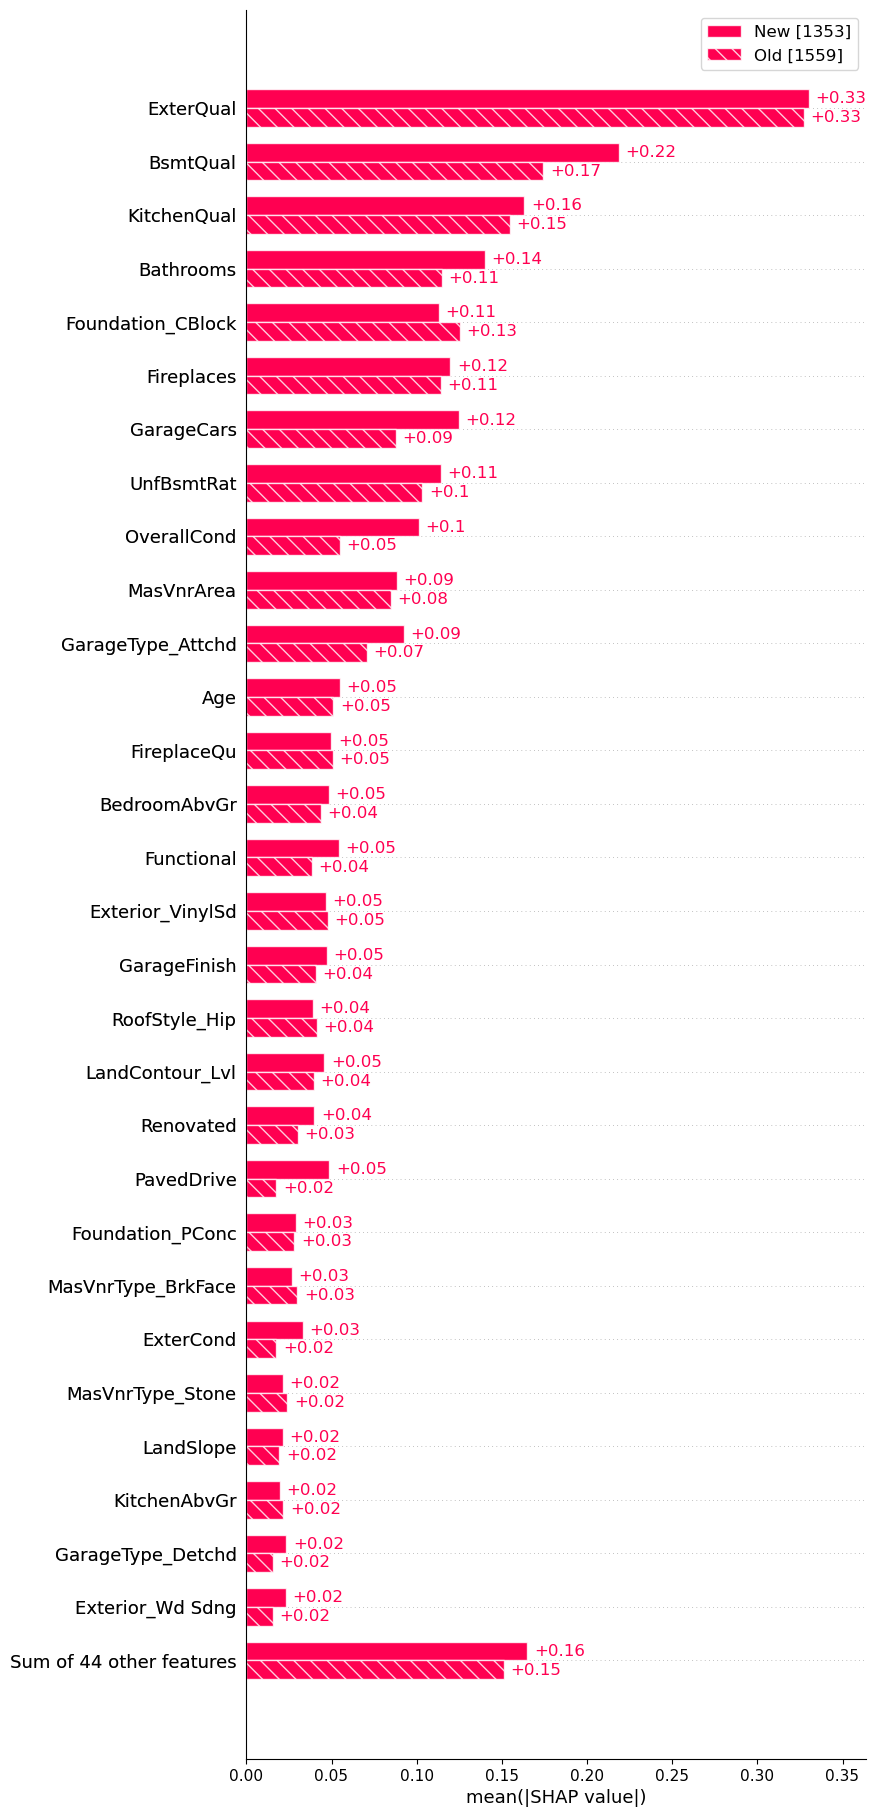

In [132]:
new = ["New" if shap_values[i,"Renovated"].data == 1 else "Old" for i in range(shap_values.shape[0])]
shap.plots.bar(shap_values.cohorts(new).abs.mean(0),max_display=30)


14

In [123]:
data_to_corrupt

,,Bathrooms,Street,LandSlope,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,...,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,UnfSqFtRatio,Age,IsNew,Renovated,GarageAge,HasPool
index,data_index,,,,,,,,,,,,,,,,,,,,,
0,0,3.5,1,2,7,5,196.0,4,3,4,3,...,1,0,0,0,0.0,5,0,0,5.0,0
1,1,2.5,1,2,6,8,0.0,3,3,4,3,...,0,0,0,0,0.0,31,0,0,31.0,0
2,2,3.5,1,2,7,5,162.0,4,3,4,3,...,1,0,0,0,0.0,6,0,1,7.0,0
3,4,3.5,1,2,8,5,350.0,4,3,4,3,...,1,0,0,0,0.0,8,0,0,8.0,0
4,6,3.0,1,2,8,5,186.0,4,3,5,3,...,1,0,0,0,0.0,2,0,1,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1570,2900,2.0,1,2,5,7,0.0,3,3,3,3,...,0,0,0,0,0.0,3,0,1,38.0,0
1571,2901,2.0,1,2,5,5,0.0,3,3,3,3,...,0,0,0,0,0.0,36,0,0,36.0,0
1572,2904,2.0,1,1,5,5,194.0,3,3,3,3,...,1,0,0,0,0.0,27,0,1,37.0,0
